In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()
matplotlib.rcParams.update({'font.size': 10})


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/shie/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)


2023-09-12 10:01:40,094 - hbmep.config - INFO - Verifying configuration ...
2023-09-12 10:01:40,094 - hbmep.config - INFO - Success!
2023-09-12 10:01:40,110 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-09-12 10:01:40,119 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-09-12 10:01:40,119 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-09-12 10:01:40,120 - hbmep.dataset.core - INFO - Processing data ...
2023-09-12 10:01:40,122 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
df.shape

(3392, 46)

In [5]:
df

,compound_position,participant,pulse_amplitude,Biceps,Triceps,APB
0,0,0,0.0,0.117726,0.034792,0.003943
1,0,0,44.0,0.145037,0.050807,0.004099
2,0,0,88.0,0.079579,0.040865,0.003469
3,0,0,132.0,0.117517,0.047211,0.003536
4,0,0,176.0,0.119749,0.311021,0.036985
...,...,...,...,...,...,...
535,0,5,176.0,0.258185,0.245615,0.048679
536,0,5,224.0,0.637872,0.609057,0.047406
537,0,5,268.0,1.235613,0.887590,0.051601
538,0,5,312.0,1.166648,1.182639,0.451890


In [7]:
scores.shape

(4, 6, 2)

In [8]:
err_mae.shape

(4, 6, 6)

In [29]:
err_mae_mean = err_mae.mean(axis=-1)
err_mse_mean = err_mse.mean(axis=-1)

err_mae_std = err_mae.std(axis=-1, ddof=1)
err_mse_std = err_mse.std(axis=-1, ddof=1)

err_mae_se = err_mae_std / np.sqrt(err_mae.shape[-1])
err_mse_se = err_mse_std / np.sqrt(err_mae.shape[-1])

Text(0.5, -0.4, '6 Participants, 3 Muscles\nH0: (m=1) == (m=3) vs H1: (m=1) < (m=3)\np-values: [0.04, 0.49, 0.6, 0.15, 0.25, 0.03]')

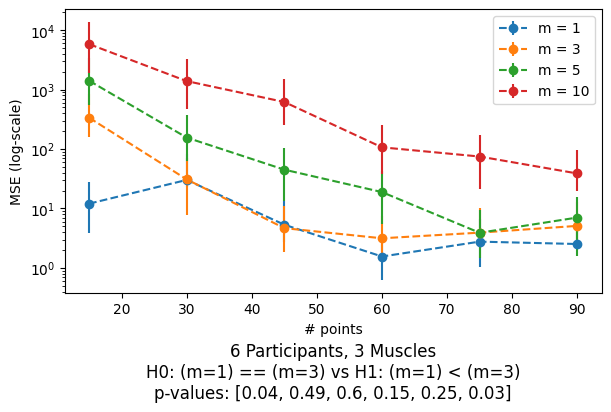

In [80]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows), squeeze=False, constrained_layout=True)

ax = axes[0, 0]

for j, m in enumerate(m_space):
    # sns.lineplot(x=N_space, y=err_mse_mean[j, ...], marker="o", linestyle="dashed", ms=8, ax=ax, label=f"m = {m}")

    ax.errorbar(
        x=N_space,
        y=err_mse_mean[j, ...],
        fmt="--",
        marker="o",
        # markersize=pt_size,
        # color=pt_color,
        # xerr=xError,
        yerr=[err_mse_mean[j, ...] - err_mse_se[j, ...], err_mse_mean[j, ...] + err_mse_se[j, ...]],
        # elinewidth=err_width,
        # capsize=err_capsize,
        # capthick=cap_width,
        # barsabove=False,
        # ecolor=err_color,
        label=f"m = {m}"
    )

ax.set(yscale='log')
ax.set_ylabel("MSE (log-scale)")
ax.set_xlabel("# points")
ax.legend(loc="upper right")
plt.title(f"6 Participants, 3 Muscles\nH0: (m=1) == (m=3) vs H1: (m=1) < (m=3)\np-values: {np.round([0.04491838, 0.48950663, 0.59609639, 0.14868006, 0.2525384, 0.02530878], 2).tolist()}", y=-0.4)

In [45]:
err_mse.shape

(4, 6, 6)

In [46]:
import scipy.stats as stats

In [48]:
err_mse[0, -1, ...] - err_mse[1, -1, ...]

(6,)

In [ ]:
m = 1 is better than m = 3 if err_mse[0, -1, ...] < err_mse[1, -1, ...] or 

In [50]:
err_mse[0, ...].shape

(6, 6)

In [53]:
stats.ttest_1samp(
    a = err_mse[0, ...] - err_mse[1, ...],
    popmean=0,
    alternative="less",
    axis=-1
)

TtestResult(statistic=array([-2.09926716, -0.02764696,  0.25646872, -1.16286974, -0.71768152,
       -2.56047188]), pvalue=array([0.04491838, 0.48950663, 0.59609639, 0.14868006, 0.2525384 ,
       0.02530878]), df=array([5, 5, 5, 5, 5, 5]))

In [49]:
stats.ttest_1samp(
    a = err_mse[0, ...] - err_mse[1, ...],
    popmean=0,
    alternative="less",
    axis=-1
)

TtestResult(statistic=-2.5604718751568867, pvalue=0.02530878353788898, df=5)

In [8]:
scores.shape

(4, 6, 2)